In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from IPython.display import clear_output
from collections import deque, namedtuple
import random
import time
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from pathlib import Path
import utils, importlib
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\patry\\Desktop\\lunar-lander\\utils.py'>

In [15]:
env_preview = gym.make('LunarLander-v3', render_mode='rgb_array')
observation_preview, info_preview = env_preview.reset(seed=42)

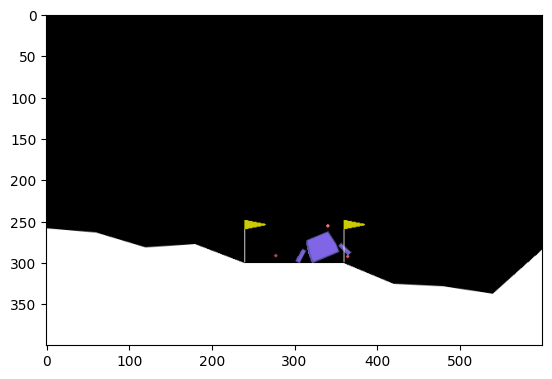

In [16]:
for _ in range(1000):
    obs_pre, reward_pre, done_pre, _, _ = env_preview.step(env_preview.action_space.sample())
    clear_output(wait=True)
    plt.imshow(env_preview.render())
    if done_pre:
        break
    plt.xticks([])
    plt.yticks([])
    plt.show()
env_preview.close()

In [17]:
env = gym.make('LunarLander-v3')
n_actions = env.action_space.n
state_shape = env.observation_space.shape

env.reset()

(array([-0.00582943,  1.4222697 , -0.5904807 ,  0.50441045,  0.00676171,
         0.1337527 ,  0.        ,  0.        ], dtype=float32),
 {})

In [52]:
hyperparameters = {
    'learning_rate': 1e-3,
    'tau': 1e-3,
    'minibatch_size': 64,
    'eps_decay_rate': 0.995,
    'gamma': 0.995,
    'eps_min': 0.01,
    'num_steps_for_update': 4,
    'min_points': 200
}

In [74]:
hyperparameters_fast_landing = {
    'learning_rate': 1e-3,
    'tau': 1e-3,
    'minibatch_size': 64,
    'eps_decay_rate': 0.995,
    'gamma': 0.990,
    'eps_min': 0.01,
    'num_steps_for_update': 4,
    'min_points': 200
}

In [91]:
hyperparameters_max = {
    'learning_rate': 1e-3,
    'tau': 1e-3,
    'minibatch_size': 64,
    'eps_decay_rate': 0.995,
    'gamma': 0.995,
    'eps_min': 0.01,
    'num_steps_for_update': 4,
    'min_points': 275
}

In [41]:
q_network = tf.keras.Sequential([
    tf.keras.Input(shape=state_shape),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=n_actions, activation=None)
])
target_q_network = tf.keras.Sequential([
    tf.keras.Input(shape=state_shape),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=n_actions, activation=None)
])
target_q_network.set_weights(q_network.get_weights())

In [42]:
learning_rate = hyperparameters['learning_rate']
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [43]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
        Calculates the loss

        Args:
            -experiences (tuple) of namedtuples
            -gamma (float): hyperparameter- how impaceint our agent is, lower means the agent will try to solve env faster
            -q_network (tf model): will be used to predict best action in given state
            -target_q_network (tf model): will be used to approximate Q(s, a)
    """
    states, actions, rewards, next_states, done_vals = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=1) # our Q function from bellman equation, we are getting best action for next_state from experiences
    y_targets = rewards + gamma * max_qsa * (1 - done_vals)

    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack((tf.range(q_values.shape[0]),                        # Making sure to calculate loss from action the agent actually did, not from the one with hithest prob, but other one was choosen because of eps greedy policy
                                                tf.cast(actions, tf.int32)), axis=1))

    loss = tf.keras.losses.MSE(y_targets, q_values)

    return loss

In [44]:
@tf.function
def agent_learn(experiences, gamma, tau):
    """
        Updates weights of Q network

        Args:
            -Experiences (tuple, dtype: tf.float32): states, actions, rewards, next_states, done_vals    | of len minibatch_size
            -Gamma (float): hyperparameter
        Returns:
            None
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    grads = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

    utils.soft_update_target(tau, target_q_network, q_network)

In [45]:
experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

In [75]:
memory_size = 100_000

num_episodes = 2500
max_num_timesteps = 1000
memory_buffer = deque(maxlen=memory_size)


def get_model(hyperparameters, model_name:str):
    epsilon = 1.0
    
    total_point_history = []
    
    start = time.time()
    
    for i in range(num_episodes):
        state, _ = env.reset()
        total_points = 0
    
        for t in range(max_num_timesteps):
            state_q = np.expand_dims(state, axis=0)
            q_values = q_network(state_q)
    
            action = utils.get_action(q_values, epsilon)
    
            next_state, reward, done, _, _ = env.step(action)
    
            memory_buffer.append(experience(state, action, reward, next_state, done))
    
            update = utils.check_update_conditions(t, memory_buffer, hyperparameters['num_steps_for_update'], hyperparameters['minibatch_size'])
    
            if update:
                minibatch = utils.get_minibatch(memory_buffer, hyperparameters['minibatch_size'])
    
                agent_learn(minibatch, hyperparameters['gamma'], hyperparameters['tau'])
    
            state = next_state.copy()
            total_points += reward
    
            if done:
                break
    
        total_point_history.append(total_points)
        epsilon = utils.get_new_eps(epsilon, hyperparameters['eps_min'], hyperparameters['eps_decay_rate'])
    
        if len(total_point_history) >= 150:
            av_latest_points = np.mean(total_point_history[-150])
    
            if (i + 1) % 150 == 0:
                print(f'Avg points from the last 150 episodes: {av_latest_points:.2f}')
    
            if av_latest_points >= hyperparameters['min_points']:
                print(f'Scored 200 points in enviorment after {i} iterations.')
                q_network.save(Path('models/' + model_name + '.h5'))
                break
    
    print(f'Total duration {((time.time() - start)/60):.2f} min')
    return total_point_history

In [76]:
total_p_hist_fast= get_model(hyperparameters_fast_landing, 'fast_lander_model')

Avg points from the last 150 episodes: -191.04
Avg points from the last 150 episodes: -61.51
Scored 200 points in enviorment after 396 iterations.
Total duration 5.17 min


In [77]:
def plot_points(total_point_history):
    iteration = np.arange(len(total_point_history))
    
    plt.plot(iteration, total_point_history)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Iteration')
    plt.ylabel('Points')
    plt.title('Earned points at iter')
    plt.show()

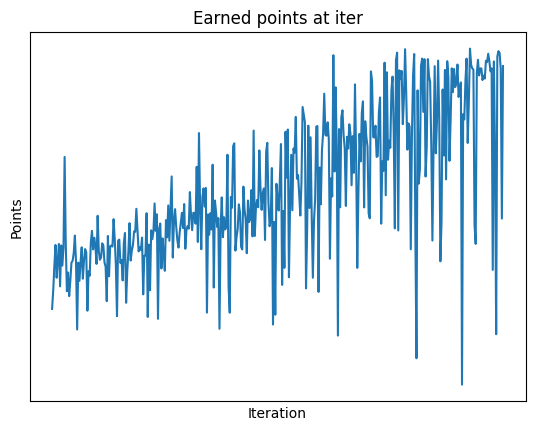

In [78]:
plot_points(total_p_hist_fast)

In [79]:
model_fast_landing = tf.keras.models.load_model(Path('models/fast_lander_model.h5'))

In [80]:
def choose_action(state, model):
    state_q = np.expand_dims(state, axis=0)
    q_values = model(state_q)
    return np.argmax(q_values.numpy()[0])


In [90]:
def show_landing(model, n=3):
    env_temp = gym.make('LunarLander-v3', render_mode='rgb_array')
    for _ in range(n):
        state, _ = env_temp.reset()
        for _ in range(400):
            state, reward, done, _, _ = env_temp.step(choose_action(state, model))
            clear_output(wait=True)
            plt.imshow(env_temp.render())
            if done:
                break
            plt.show()
    env_preview.close()

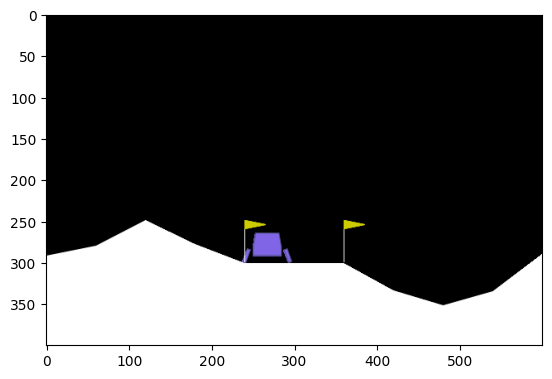

In [89]:
show_landing(model_fast_landing)

In [71]:
def save_video(folder_name:str, model, n=3):
    os.makedirs("videos/" + folder_name, exist_ok=True)
    
    
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    
    
    env = RecordVideo(
        env,
        video_folder="videos/" + folder_name,
        name_prefix="eval",
        episode_trigger=lambda ep: True,  
    )
    env = RecordEpisodeStatistics(env, buffer_length=n)
    
    
    for i in range(n):                    
        state, info = env.reset()        
        for t in range(1000):
            action = choose_action(state, model) 
            state, reward, terminated, truncated, info = env.step(action)
            if terminated or truncated:     
                break
    
    
    env.close()
    print("Zapisane do folderu 'videos/" + folder_name + "'")


In [ ]:
model_max = get_model(hyperparameters_max, 'model_max')

Avg points from the last 150 episodes: -322.39
